# Deconfounder on Book Recommendation

## Setup

In [4]:
import os
import sys
import pickle
import warnings
import numpy as np 
import pandas as pd 
from ast import literal_eval
import matplotlib
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from sklearn.model_selection import train_test_split



matplotlib.rcParams.update({'font.sans-serif' : 'Helvetica',
                            'axes.labelsize': 10,
                            'xtick.labelsize' : 6,
                            'ytick.labelsize' : 6,
                            'axes.titlesize' : 10})
import matplotlib.pyplot as plt

import seaborn as sns
color_names = ["windows blue",
               "amber",
               "crimson",
               "faded green",
               "dusty purple",
               "greyish"]
colors = sns.xkcd_palette(color_names)
sns.set(style="white", palette=sns.xkcd_palette(color_names), color_codes = False)


randseed = 29266137

In [5]:
DATA_DIR = '/content/'


In [6]:
users = pd.read_csv(os.path.join(DATA_DIR, 'users_clean.csv'))
books = pd.read_csv(os.path.join(DATA_DIR, 'books_clean.csv'))
ratings = pd.read_csv(os.path.join(DATA_DIR, 'ratings_clean.csv'))

In [7]:
#rename User-ID and ISBN 
ratings.rename({"User-ID": "userId", "ISBN": "bookId", "Book-Rating":"rating"}, axis=1, inplace=True)
users.rename({"User-ID": "userId"}, axis=1, inplace=True)
books.rename({"ISBN": "bookId"}, axis=1, inplace=True)

In [8]:
ratings.head()

,userId,bookId,rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [9]:
users.head()

,userId,Location,Age
0,1,"nyc, new york, usa",34
1,2,"stockton, california, usa",18
2,3,"moscow, yukon territory, russia",34
3,4,"porto, v.n.gaia, portugal",17
4,5,"farnborough, hants, united kingdom",34


In [10]:
books.head()

,bookId,bookTitle,bookAuthor,yearOfPublication,publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company


In [11]:
# get explicit ratings, where we select ratings having non-zero values
ratings_explicit = ratings[ratings['rating'] != 0]

ratings.shape , ratings_explicit.shape

((1031136, 3), (383842, 3))

In [12]:
ratings_explicit.head()

,userId,bookId,rating
1,276726,0155061224,5
3,276729,052165615X,3
4,276729,0521795028,6
6,276744,038550120X,7
13,276747,0060517794,9


In [13]:
# Only see which users and books have been rated more than 5 times

#User count
v = ratings_explicit.userId.value_counts()
rating_user = ratings_explicit[ratings_explicit.userId.isin(v.index[v.gt(5)])]
rating_user

,userId,bookId,rating
99,276822,0060096195,10
100,276822,0141310340,9
101,276822,0142302198,10
102,276822,0156006065,9
103,276822,0375821813,9
...,...,...,...
1031101,276688,0836218655,10
1031102,276688,0836236688,10
1031103,276688,0892966548,10
1031104,276688,1551669315,6


In [14]:
#book count
v = rating_user.bookId.value_counts()
df = rating_user[rating_user.bookId.isin(v.index[v.gt(5)])]
df.reset_index(drop=True)


,userId,bookId,rating
0,276822,0060096195,10
1,276822,0375821813,9
2,276822,0786817070,10
3,276847,3442437717,7
4,276847,3442446414,10
...,...,...,...
116383,276688,0553575104,6
116384,276688,0688156134,8
116385,276688,0743202694,10
116386,276688,0836218655,10


## PMF


In [15]:
# Sparse review matrix

def get_ratings_matrix(df, train_size=0.75):
    user_to_row = {}
    book_to_column = {}
    df_values = df.values
    n_dims = 10
    parameters = {}
    
    uniq_users = np.unique(df_values[:, 0])
    uniq_books = np.unique(df_values[:, 1])

    for i, user_id in enumerate(uniq_users):
        user_to_row[user_id] = i

    for j, movie_id in enumerate(uniq_books):
        book_to_column[movie_id] = j
    
    n_users = len(uniq_users)
    n_books = len(uniq_books)
    
    R = np.zeros((n_users, n_books))
    
    df_copy = df.copy()
    train_set = df_copy.sample(frac=train_size, random_state=0)
    test_set = df_copy.drop(train_set.index)
    
    for index, row in train_set.iterrows():
        i = user_to_row[row.userId]
        j = book_to_column[row.bookId]
        R[i, j] = row.rating

    return R, train_set, test_set, n_dims, n_users, n_books, user_to_row, book_to_column

In [16]:
R, train_set, test_set, n_dims, n_users, n_movies, user_to_row, book_to_column = get_ratings_matrix(df, 0.8)
parameters = {}

In [17]:
# Initialise parameters. N: n_users, M: n_nooks, D: n_dims
# V~N(0, 1/lambda_V), U.shape:(D,N), V.shape = (D,M)

def initialize_parameters(lambda_U, lambda_V):
    U = np.zeros((n_dims, n_users), dtype=np.float64)
    V = np.random.normal(0.0, 1.0 / lambda_V, (n_dims, n_movies))
    
    parameters['U'] = U
    parameters['V'] = V
    parameters['lambda_U'] = lambda_U
    parameters['lambda_V'] = lambda_V

In [18]:
#Update U and V
def update_parameters():
    U = parameters['U']
    V = parameters['V']
    lambda_U = parameters['lambda_U']
    lambda_V = parameters['lambda_V']
    
    for i in range(n_users):
        V_j = V[:, R[i, :] > 0]
        U[:, i] = np.dot(np.linalg.inv(np.dot(V_j, V_j.T) + lambda_U * np.identity(n_dims)), np.dot(R[i, R[i, :] > 0], V_j.T))
        
    for j in range(n_movies):
        U_i = U[:, R[:, j] > 0]
        V[:, j] = np.dot(np.linalg.inv(np.dot(U_i, U_i.T) + lambda_V * np.identity(n_dims)), np.dot(R[R[:, j] > 0, j], U_i.T))
        
    parameters['U'] = U
    parameters['V'] = V

In [19]:
#Implement log-a posteriori
def log_a_posteriori():
    lambda_U = parameters['lambda_U']
    lambda_V = parameters['lambda_V']
    U = parameters['U']
    V = parameters['V']
    
    UV = np.dot(U.T, V)
    R_UV = (R[R > 0] - UV[R > 0])
    
    return -0.5 * (np.sum(np.dot(R_UV, R_UV.T)) + lambda_U * np.sum(np.dot(U, U.T)) + lambda_V * np.sum(np.dot(V, V.T)))

In [20]:
#The predict function allows us to predict the rating value given the user_id and the book_id parameters. The value has been scaled within the range 0-5
def predict(user_id, book_id):
    U = parameters['U']
    V = parameters['V']
    
    r_ij = U[:, user_to_row[user_id]].T.reshape(1, -1) @ V[:, book_to_column[book_id]].reshape(-1, 1)

    max_rating = parameters['max_rating']
    min_rating = parameters['min_rating']

    return 0 if max_rating == min_rating else ((r_ij[0][0] - min_rating) / (max_rating - min_rating)) * 5.0

In [21]:
#The evaluate function will calculate the RMSE of the model given a dataset (train or test).
def evaluate(dataset):
    ground_truths = []
    predictions = []
    
    for index, row in dataset.iterrows():
        ground_truths.append(row.loc['rating'])
        predictions.append(predict(row.loc['userId'], row.loc['bookId']))
    
    return mean_squared_error(ground_truths, predictions, squared=False)

In [22]:
#For the purposes of scaling, we need the maximum and minimum rating values.

def update_max_min_ratings():
    U = parameters['U']
    V = parameters['V']

    R = U.T @ V
    min_rating = np.min(R)
    max_rating = np.max(R)

    parameters['min_rating'] = min_rating
    parameters['max_rating'] = max_rating

In [23]:
#The train function implements the code necessary for training the model as well as recording the RMSE values on the training and testing sets.
def train(n_epochs):
    initialize_parameters(0.3, 0.3)
    log_aps = []
    rmse_train = []
    rmse_test = []

    update_max_min_ratings()
    rmse_train.append(evaluate(train_set))
    rmse_test.append(evaluate(test_set))
    
    for k in range(n_epochs):
        update_parameters()
        log_ap = log_a_posteriori()
        log_aps.append(log_ap)

        if (k + 1) % 10 == 0:
            update_max_min_ratings()

            rmse_train.append(evaluate(train_set))
            rmse_test.append(evaluate(test_set))
            print('Log p a-posteriori at iteration', k + 1, ':', log_ap)

    update_max_min_ratings()

    return log_aps, rmse_train, rmse_test, parameters

In [24]:
log_ps, rmse_train, rmse_test, p = train(200)

Log p a-posteriori at iteration 10 : -40461.94301796214
Log p a-posteriori at iteration 20 : -21579.191183909694
Log p a-posteriori at iteration 30 : -17114.456920068962
Log p a-posteriori at iteration 40 : -15522.739533422044
Log p a-posteriori at iteration 50 : -14691.647736958259
Log p a-posteriori at iteration 60 : -14135.461090224631
Log p a-posteriori at iteration 70 : -13771.68948117024
Log p a-posteriori at iteration 80 : -13491.886322318383
Log p a-posteriori at iteration 90 : -13285.315519910346
Log p a-posteriori at iteration 100 : -13120.931498071503
Log p a-posteriori at iteration 110 : -13005.877219934742
Log p a-posteriori at iteration 120 : -12945.652919680357
Log p a-posteriori at iteration 130 : -12927.601102191164
Log p a-posteriori at iteration 140 : -12927.333794378494
Log p a-posteriori at iteration 150 : -12925.865996419285
Log p a-posteriori at iteration 160 : -12916.08610980006
Log p a-posteriori at iteration 170 : -12905.590774412325
Log p a-posteriori at iter

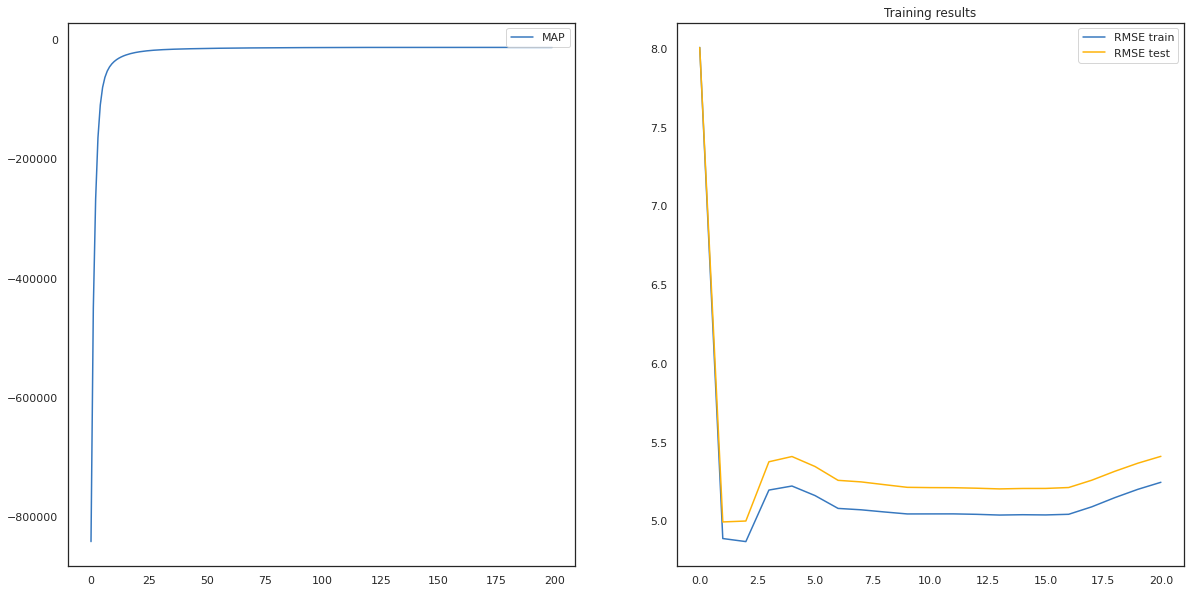

In [25]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
plt.title('Training results')
ax1.plot(np.arange(len(log_ps)), log_ps, label='MAP')
ax1.legend()

ax2.plot(np.arange(len(rmse_train)), rmse_train, label='RMSE train')
ax2.plot(np.arange(len(rmse_test)), rmse_test, label='RMSE test')
ax2.legend()

plt.show()

In [26]:
print('RMSE of training set:', evaluate(train_set))
print('RMSE of testing set:', evaluate(test_set))

RMSE of training set: 5.245156528810994
RMSE of testing set: 5.409901241820704


## Deconfounder

In [27]:
# Prepare Exposure
def exposure_data(df, train_size=0.75):
    user_to_row = {}
    book_to_column = {}
    
    uniq_users = np.unique(df['userId'])
    uniq_books = np.unique(df['bookId'])

    for i, user_id in enumerate(uniq_users):
        user_to_row[user_id] = i

    for j, movie_id in enumerate(uniq_books):
        book_to_column[movie_id] = j
    
    data = []
    n_users = len(uniq_users)
    n_books = len(uniq_books)
    for row in df.iterrows():
      user, book = row[1][0], row[1][1]
      data.append((user_to_row[user], book_to_column[book], 1))

    exposure_df = pd.DataFrame(data, columns =['userID', 'bookID', 'a'])
    #Train-test split
    df_copy = exposure_df.copy()
    train_set = df_copy.sample(frac=train_size, random_state=0)
    test_set = df_copy.drop(train_set.index)
    
    return exposure_df, train_set, test_set, n_users, n_books, user_to_row, book_to_column


exposure_df, train, test, n_users, n_books, user_to_row, book_to_column = exposure_data(df)

In [28]:
#Fit exposure
! pip install hpfrec
import pandas as pd, numpy as np
from hpfrec import HPF


In [29]:
exposure_df.columns = ['UserId', 'ItemId', 'Count']
recommender = HPF()
param = recommender.fit(exposure_df)

**********************************
Hierarchical Poisson Factorization
**********************************

Number of users: 10177
Number of items: 7833
Latent factors to use: 30

Initializing parameters...
Allocating Phi matrix...
Initializing optimization procedure...
Iteration 10 | train llk: -747091 | train rmse: 0.9848
Iteration 20 | train llk: -686413 | train rmse: 0.9736
Iteration 30 | train llk: -679177 | train rmse: 0.9710
Iteration 40 | train llk: -675910 | train rmse: 0.9699
Iteration 50 | train llk: -673933 | train rmse: 0.9693
Iteration 60 | train llk: -672651 | train rmse: 0.9689
Iteration 70 | train llk: -671767 | train rmse: 0.9686
Iteration 80 | train llk: -671167 | train rmse: 0.9684
Iteration 90 | train llk: -670713 | train rmse: 0.9682
Iteration 100 | train llk: -670373 | train rmse: 0.9681


Optimization finished
Final log-likelihood: -670373
Final RMSE: 0.9681
Minutes taken (optimization part): 0.9



In [30]:
def matrix_X(R):
  X = []
  for i in range(len(R)):
    row = [1 if val == 1 else 0 for val in R[i]]
    X.append(row)
  return X

X = matrix_X(R)
ratings = df['rating']
y = R
pmfU = param.Theta

y_scaler = preprocessing.StandardScaler().fit(y)
y_scaled = y_scaler.fit_transform(y)

X_scaler = preprocessing.StandardScaler().fit(X)
X_scaled = X_scaler.fit_transform(X)

pmfU_scaler = preprocessing.StandardScaler().fit(pmfU)
pmfU_scaled = pmfU_scaler.fit_transform(pmfU)

X_train, X_test = train_test_split(X_scaled, test_size=0.20, random_state=randseed)
y_train, y_test = train_test_split(y_scaled, test_size=0.20, random_state=randseed)
pmfU_train, pmfU_test = train_test_split(pmfU_scaled, test_size=0.20, random_state=randseed)
n_users, n_items = X_train.shape

In [31]:
#fit outcome model
import warnings
warnings.filterwarnings('ignore')
reg = linear_model.Ridge(normalize=True)
for i in range(n_items):
    # if i%100 == 0:
    #   print('---- Fitting row', i, '----')
    reg.fit(np.column_stack([X_train[:,i], pmfU_train]), y_train[:,i])

In [32]:
#estimate potential ratings
test_items = X_test.shape[1]
prediction = []

for i in range(test_items):
    # if i%100 == 0:
    #   print('---- Predicting row', i, '----')
    res = reg.predict(np.column_stack([X_test[:,i], pmfU_test]))
    prediction.append(res)

In [33]:
#evaluate model
y_test = np.transpose(y_test)
rmse = mean_squared_error(y_test, prediction, squared=False)
print(rmse)

0.8142122801076331


In [34]:

# load pickle module
import pickle


# create a binary pickle file 
f = open(os.path.join(DATA_DIR, "book_params_pmf.pkl"),"wb")

# write the python object (dict) to pickle file
pickle.dump(p,f)

# close file
f.close()

In [35]:
# create a binary pickle file 
f = open(os.path.join(DATA_DIR, "book_pmfu.pkl"),"wb")

# write the python object (dict) to pickle file
pickle.dump(pmfU,f)

# close file
f.close()